Meta data extraction using LLM to be fed into RL systems

In [ ]:
import sys
import subprocess
import warnings

warnings.filterwarnings('ignore')

print("Installing dependencies...")
packages = ['praw', 'transformers', 'torch', 'pandas', 'numpy']
for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

import praw
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from collections import defaultdict


Installing dependencies...


In [ ]:
from google.colab import userdata
# REDDIT
CLIENT_ID = "aq-2pxMG9ttgc4SWXu_QTw"
CLIENT_SECRET = "lBnvo65CKWRFbE7XGM8AXkPNXj7X6g"
USER_AGENT = "FinancialSentimentAnalysis/1.0"
USERNAME = "Sad_View_5744"
PASSWORD = "Aditya@2001"

try:
    reddit = praw.Reddit(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        user_agent=USER_AGENT,
        username=USERNAME,
        password=PASSWORD
    )

    # Test connection
    reddit.user.me()
    print("Connected to Reddit successfully!\n")
    USE_REDDIT = True
except Exception as e:
    print(f"ERROR: Could not connect to Reddit: {e}")
    print("Make sure PASSWORD is correct!\n")
    USE_REDDIT = False

subreddit_queries = {
    "SP_500": ["r/stocks", "S&P 500"],
    "NASDAQ": ["r/stocks", "NASDAQ"],
    "Dow_Jones": ["r/stocks", "Dow Jones"],
    "Gold": ["r/investing", "gold prices"],
    "Silver": ["r/investing", "silver prices"],
    "Oil": ["r/investing", "oil prices"]
}

print("STEP 1/5: Collecting posts from Reddit...")

all_posts = defaultdict(list)
total_posts = 0

if USE_REDDIT:
    subreddits_to_check = set(q[0] for q in subreddit_queries.values())

    for subreddit_name in subreddits_to_check:
        print(f"\nFetching from {subreddit_name}...")
        try:
            subreddit = reddit.subreddit(subreddit_name.replace("r/", ""))

            for submission in subreddit.new(limit=100):
                title = submission.title
                body = submission.selftext if submission.selftext else ""
                comments_text = ""

                try:
                    submission.comments.replace_more(limit=0)
                    for comment in submission.comments[:10]:
                        comments_text += comment.body + " "
                except:
                    pass

                content = title + " " + body + " " + comments_text

                for asset, (sub, keywords) in subreddit_queries.items():
                    if sub == subreddit_name:
                        if any(keyword.lower() in content.lower() for keyword in keywords):
                            all_posts[asset].append(content)

            print(f"  Found posts for multiple assets")
        except Exception as e:
            print(f"  Error: {e}")

    total_posts = sum(len(posts) for posts in all_posts.values())
    print(f"\nTotal posts collected: {total_posts}\n")

else:
    print("connection failed\n")




It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Connected to Reddit successfully!

STEP 1/5: Collecting posts from Reddit...

Fetching from r/investing...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  Found posts for multiple assets

Fetching from r/stocks...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

  Found posts for multiple assets

Total posts collected: 600



In [ ]:

# CLEAN & PREPARE DATA

articles_for_sentiment = []
for asset_name, posts in all_posts.items():
    for post in posts:
        if len(post) > 50:
            first_500_words = ' '.join(post.split()[:500])
            volatility_keywords = ['crash', 'surge', 'plunge', 'volatile', 'uncertainty',
                                  'crisis', 'boom', 'panic', 'rally', 'collapse', 'shock',
                                  'extreme', 'risk', 'bull', 'bear']
            volatility_count = sum(1 for word in volatility_keywords if word.lower() in post.lower())

            articles_for_sentiment.append({
                'asset': asset_name,
                'content': first_500_words,
                'volatility_keywords': volatility_count
            })

print(f"Total text samples prepared: {len(articles_for_sentiment)}\n")

Total text samples prepared: 600



In [ ]:
# FINBERT

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

if torch.cuda.is_available():
    model = model.to('cuda')
    print("Model loaded on GPU\n")
else:
    print("Model loaded on CPU\n")

# SENTIMENT ANALYSIS
def analyze_sentiment(text):
    if not isinstance(text, str) or len(text) < 10:
        return 'neutral', 0.0, 0.0, 0.0, 0.0

    inputs = tokenizer(text[:512], return_tensors="pt", truncation=True, padding=True)
    if torch.cuda.is_available():
        inputs = {k: v.to('cuda') for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_idx = torch.argmax(probs, dim=1).item()
    confidence = probs[0][sentiment_idx].item()

    sentiment_map = {0: 'positive', 1: 'negative', 2: 'neutral'}
    return sentiment_map[sentiment_idx], confidence, probs[0][0].item(), probs[0][1].item(), probs[0][2].item()


for idx, article in enumerate(articles_for_sentiment):
    sentiment, conf, p_pos, p_neg, p_neu = analyze_sentiment(article['content'])
    article['sentiment_label'] = sentiment
    article['sentiment_confidence'] = conf
    article['prob_positive'] = p_pos
    article['prob_negative'] = p_neg
    article['prob_neutral'] = p_neu

    if (idx + 1) % 50 == 0 and idx > 0:
        print(f"  Analyzed {idx + 1}/{len(articles_for_sentiment)} texts")

print(f"Sentiment analysis complete\n")


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Model loaded on CPU

  Analyzed 50/600 texts
  Analyzed 100/600 texts
  Analyzed 150/600 texts
  Analyzed 200/600 texts
  Analyzed 250/600 texts
  Analyzed 300/600 texts
  Analyzed 350/600 texts
  Analyzed 400/600 texts
  Analyzed 450/600 texts
  Analyzed 500/600 texts
  Analyzed 550/600 texts
  Analyzed 600/600 texts
Sentiment analysis complete



In [ ]:

# AGGREGATE FEATURES

daily_features = []
assets = list(set(a['asset'] for a in articles_for_sentiment))

for asset_name in assets:
    asset_articles = [a for a in articles_for_sentiment if a['asset'] == asset_name]

    if len(asset_articles) > 0:
        count_positive = sum(1 for a in asset_articles if a['sentiment_label'] == 'positive')
        count_negative = sum(1 for a in asset_articles if a['sentiment_label'] == 'negative')

        sentiment_score = (count_positive - count_negative) / len(asset_articles) if len(asset_articles) > 0 else 0.0
        sentiment_volatility = np.std([a['prob_positive'] for a in asset_articles]) if len(asset_articles) > 1 else 0.0
        volatility_signal = np.mean([a['volatility_keywords'] for a in asset_articles])
        article_frequency = len(asset_articles)
        sentiment_confidence = np.mean([a['sentiment_confidence'] for a in asset_articles])

        daily_features.append({
            'Asset': asset_name,
            'Date': datetime.now().strftime("%Y-%m-%d"),
            'sentiment_score': sentiment_score,
            'sentiment_volatility': sentiment_volatility,
            'volatility_signal': volatility_signal,
            'article_frequency': article_frequency,
            'sentiment_confidence': sentiment_confidence,
            'count_positive': count_positive,
            'count_negative': count_negative,
            'total_posts': len(asset_articles)
        })

df_daily = pd.DataFrame(daily_features)
df_daily.to_csv('daily_llm_features_reddit.csv', index=False)

# Create observation vector
obs_vector = []
asset_order = ["SP_500", "NASDAQ", "Dow_Jones", "Gold", "Silver", "Oil"]

for asset in asset_order:
    asset_data = df_daily[df_daily['Asset'] == asset]
    if len(asset_data) > 0:
        row = asset_data.iloc[0]
        obs_vector.extend([
            row['sentiment_score'],
            row['sentiment_volatility'],
            row['volatility_signal'],
            row['article_frequency'] / 100.0,
            row['sentiment_confidence']
        ])
    else:
        obs_vector.extend([0, 0, 0, 0, 0])

obs_df = pd.DataFrame([obs_vector], columns=[
    'SP_500_sentiment_score', 'SP_500_sentiment_volatility', 'SP_500_volatility_signal', 'SP_500_article_frequency', 'SP_500_sentiment_confidence',
    'NASDAQ_sentiment_score', 'NASDAQ_sentiment_volatility', 'NASDAQ_volatility_signal', 'NASDAQ_article_frequency', 'NASDAQ_sentiment_confidence',
    'Dow_Jones_sentiment_score', 'Dow_Jones_sentiment_volatility', 'Dow_Jones_volatility_signal', 'Dow_Jones_article_frequency', 'Dow_Jones_sentiment_confidence',
    'Gold_sentiment_score', 'Gold_sentiment_volatility', 'Gold_volatility_signal', 'Gold_article_frequency', 'Gold_sentiment_confidence',
    'Silver_sentiment_score', 'Silver_sentiment_volatility', 'Silver_volatility_signal', 'Silver_article_frequency', 'Silver_sentiment_confidence',
    'Oil_sentiment_score', 'Oil_sentiment_volatility', 'Oil_volatility_signal', 'Oil_article_frequency', 'Oil_sentiment_confidence'
])

obs_df.to_csv('rl_observation_vectors_llm_reddit.csv', index=False)



print(f"\nSamples analyzed: {len(articles_for_sentiment)}")
print(f"Assets covered: {len(assets)}")
print(f"Output: rl_observation_vectors_llm_reddit.csv")
print("\nSentiment Summary:")
print(df_daily[['Asset', 'sentiment_score', 'count_positive', 'count_negative', 'total_posts']])




Samples analyzed: 600
Assets covered: 6
Output: rl_observation_vectors_llm_reddit.csv

Sentiment Summary:
       Asset  sentiment_score  count_positive  count_negative  total_posts
0       Gold            -0.11              11              22          100
1        Oil            -0.11              11              22          100
2     NASDAQ            -0.15              15              30          100
3  Dow_Jones            -0.15              15              30          100
4     SP_500            -0.15              15              30          100
5     Silver            -0.11              11              22          100


In [ ]:
import pandas as pd
import os

print("VERIFYING OUTPUT FILES")

# Check if files exist
files = ['rl_observation_vectors_llm_reddit.csv', 'daily_llm_reddit.csv']

for file in files:
    if os.path.exists(file):
        df = pd.read_csv(file)
        print(f"File: {file}")
        print(f"  Shape: {df.shape}")
        print(f"  Columns: {list(df.columns)[:5]}...")
        print(f"  Data:\n{df.head(2)}\n")
    else:
        print(f"File NOT found: {file}\n")

# Load the actual RL observation vector
obs = pd.read_csv('rl_observation_vectors_llm_reddit.csv')

print("RL OBSERVATION VECTOR (30 features)")

print(f"\nShape: {obs.shape}")
print(f"Features: {list(obs.columns)}")
print(f"\nFirst 10 features (values):")
for i, col in enumerate(list(obs.columns)[:10]):
    print(f"  {col}: {obs[col].values[0]:.4f}")




VERIFYING OUTPUT FILES
File: rl_observation_vectors_llm_reddit.csv
  Shape: (1, 30)
  Columns: ['SP_500_sentiment_score', 'SP_500_sentiment_volatility', 'SP_500_volatility_signal', 'SP_500_article_frequency', 'SP_500_sentiment_confidence']...
  Data:
   SP_500_sentiment_score  SP_500_sentiment_volatility  \
0                   -0.15                     0.263307   

   SP_500_volatility_signal  SP_500_article_frequency  \
0                      1.56                       1.0   

   SP_500_sentiment_confidence  NASDAQ_sentiment_score  \
0                     0.778343                   -0.15   

   NASDAQ_sentiment_volatility  NASDAQ_volatility_signal  \
0                     0.263307                      1.56   

   NASDAQ_article_frequency  NASDAQ_sentiment_confidence  ...  \
0                       1.0                     0.778343  ...   

   Silver_sentiment_score  Silver_sentiment_volatility  \
0                   -0.11                     0.258929   

   Silver_volatility_signal  Si

Testing on Small Test Dataset (2 assets, 3 months)

In [ ]:
# Market Data

import subprocess
import sys

print("Installing yfinance...")
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'yfinance'])

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Start with 2 assets for testing
TEST_TICKERS = {
    'SP_500': '^GSPC',
    'Gold': 'GC=F'
}

print("\nFetching market data (2 assets, 3 months)...")

# Fetch 3 months of data
end_date = datetime.now()
start_date = end_date - timedelta(days=90)

market_data = {}
for asset, ticker in TEST_TICKERS.items():
    print(f"  Downloading {asset}...")
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)

    # Calculate returns
    df['Returns'] = df['Close'].pct_change()
    df['Volatility'] = df['Returns'].rolling(window=10).std()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()

    df['Returns'] = df['Returns'].fillna(0)
    df['Volatility'] = df['Volatility'].fillna(0.01)
    df['SMA_20'] = df['SMA_20'].fillna(method='bfill').fillna(method='ffill')

    market_data[asset] = df

print(f"\n✓ Market data collected for {len(TEST_TICKERS)} assets")
print(f"  Date range: {start_date.date()} to {end_date.date()}")
print(f"  Data points: {len(market_data['SP_500'])}")

Installing yfinance...

Fetching market data (2 assets, 3 months)...

✓ Market data collected for 2 assets
  Date range: 2025-08-23 to 2025-11-21
  Data points: 64


In [ ]:
# Base Portfolio Environment

import subprocess
import sys

subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'gymnasium'])

import gymnasium as gym
from gymnasium import spaces
import numpy as np

class BasePortfolioEnv(gym.Env):
    def __init__(self, market_data, sentiment_features, initial_balance=100000):
        super(BasePortfolioEnv, self).__init__()

        self.market_data = market_data
        self.sentiment_features = sentiment_features
        self.initial_balance = initial_balance

        self.n_assets = 2
        self.asset_names = ['SP_500', 'Gold']

        # Get historical data length
        self.max_steps = min(len(df) for df in market_data.values()) - 1

        self.action_space = spaces.Box(
            low=0, high=1, shape=(self.n_assets,), dtype=np.float32
        )

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(17,), dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.data_index = 0
        self.portfolio_value = self.initial_balance

        return self._get_observation(), {}

    def _get_observation(self):
        # Extract sentiment for 2 assets
        sentiment_2assets = np.concatenate([
            self.sentiment_features[0:5],   # SP_500
            self.sentiment_features[15:20]  # Gold
        ])

        obs = np.concatenate([
            sentiment_2assets.flatten(),
            self._get_current_returns().flatten(),
            self._get_current_volatility().flatten(),
            self._get_price_trends().flatten(),
            np.array([self.portfolio_value / self.initial_balance]).flatten()
        ])
        return obs.astype(np.float32)

    def _get_current_returns(self):
        returns = []
        for asset in self.asset_names:
            asset_data = self.market_data[asset]
            if self.data_index < len(asset_data):
                ret = asset_data['Returns'].iloc[self.data_index]
                returns.append(ret if not np.isnan(ret) else 0.0)
            else:
                returns.append(0.0)
        return np.array(returns)

    def _get_current_volatility(self):
        volatility = []
        for asset in self.asset_names:
            asset_data = self.market_data[asset]
            if self.data_index < len(asset_data):
                vol = asset_data['Volatility'].iloc[self.data_index]
                volatility.append(vol if not np.isnan(vol) else 0.01)
            else:
                volatility.append(0.01)
        return np.array(volatility)

    def _get_price_trends(self):
        trends = []
        for asset in self.asset_names:
            asset_data = self.market_data[asset]
            if self.data_index < len(asset_data):
                current_price = asset_data['Close'].iloc[self.data_index]
                sma = asset_data['SMA_20'].iloc[self.data_index]
                trend = (current_price - sma) / sma if sma != 0 else 0
                trends.append(trend)
            else:
                trends.append(0.0)
        return np.array(trends)

    def step(self, action):
        action = np.array(action)
        action = np.clip(action, 0, 1)
        action = action / (action.sum() + 1e-8)

        returns = self._get_current_returns()

        portfolio_return = np.dot(action, returns)

        old_value = self.portfolio_value
        self.portfolio_value = old_value * (1 + portfolio_return)

        reward = portfolio_return

        self.data_index += 1
        self.current_step += 1

        terminated = self.data_index >= self.max_steps or self.current_step >= 50
        truncated = False

        return self._get_observation(), reward, terminated, truncated, {
            'portfolio_value': self.portfolio_value,
            'return': portfolio_return,
            'allocation': action.copy()
        }

# Create environment
sentiment_features_2assets = obs_df.values[0]

print("\n✓ Base Portfolio Environment created")
env_test = BasePortfolioEnv(market_data, sentiment_features_2assets)
print(f"  Action space: {env_test.action_space}")
print(f"  Observation space: {env_test.observation_space}")
print(f"  Historical data points: {env_test.max_steps}")
print(f"  Using REAL historical returns")


✓ Base Portfolio Environment created
  Action space: Box(0.0, 1.0, (2,), float32)
  Observation space: Box(-inf, inf, (17,), float32)
  Historical data points: 63
  Using REAL historical returns


In [ ]:
# Train 4 Base Agents

import subprocess
import sys

subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'stable-baselines3'])

from stable_baselines3 import PPO, SAC, DDPG, TD3
from stable_baselines3.common.vec_env import DummyVecEnv
import time

print("Training 4 base agents")

# Create separate environments for each agent
def make_env():
    return BasePortfolioEnv(market_data, sentiment_features_2assets)

# Dictionary to store trained models
base_agents = {}


TIMESTEPS = 10000

# 1. Train PPO
print("\n[1/4] Training PPO Base Agent...")
start_time = time.time()
ppo_env = DummyVecEnv([make_env])
ppo_model = PPO(
    "MlpPolicy",
    ppo_env,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    verbose=0
)
ppo_model.learn(total_timesteps=TIMESTEPS)
base_agents['PPO'] = ppo_model
print(f"PPO trained in {time.time() - start_time:.1f}s")

# 2. Train SAC
print("\n[2/4] Training SAC Base Agent...")
start_time = time.time()
sac_env = DummyVecEnv([make_env])
sac_model = SAC(
    "MlpPolicy",
    sac_env,
    learning_rate=3e-4,
    buffer_size=100000,
    batch_size=256,
    gamma=0.99,
    verbose=0
)
sac_model.learn(total_timesteps=TIMESTEPS)
base_agents['SAC'] = sac_model
print(f"SAC trained in {time.time() - start_time:.1f}s")

# 3. Train DDPG
print("\n[3/4] Training DDPG Base Agent...")
start_time = time.time()
ddpg_env = DummyVecEnv([make_env])
ddpg_model = DDPG(
    "MlpPolicy",
    ddpg_env,
    learning_rate=1e-3,
    buffer_size=100000,
    batch_size=128,
    gamma=0.99,
    verbose=0
)
ddpg_model.learn(total_timesteps=TIMESTEPS)
base_agents['DDPG'] = ddpg_model
print(f" DDPG trained in {time.time() - start_time:.1f}s")

# 4. Train TD3
print("\n[4/4] Training TD3 Base Agent...")
start_time = time.time()
td3_env = DummyVecEnv([make_env])
td3_model = TD3(
    "MlpPolicy",
    td3_env,
    learning_rate=1e-3,
    buffer_size=100000,
    batch_size=128,
    gamma=0.99,
    verbose=0
)
td3_model.learn(total_timesteps=TIMESTEPS)
base_agents['TD3'] = td3_model
print(f"TD3 trained in {time.time() - start_time:.1f}s")


print("4 agents trained!")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Training 4 base agents

[1/4] Training PPO Base Agent...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


PPO trained in 97.3s

[2/4] Training SAC Base Agent...
SAC trained in 376.9s

[3/4] Training DDPG Base Agent...
 DDPG trained in 278.0s

[4/4] Training TD3 Base Agent...
TD3 trained in 281.4s
4 agents trained!


Evaluating agents...

Evaluating PPO...
  Final Value: $106,408.29
  Total Return: 6.41%
  Sharpe Ratio: 3.095

Evaluating SAC...
  Final Value: $90,342.12
  Total Return: -9.66%
  Sharpe Ratio: -2.649

Evaluating DDPG...
  Final Value: $146,449.00
  Total Return: 46.45%
  Sharpe Ratio: 13.790

Evaluating TD3...
  Final Value: $111,794.07
  Total Return: 11.79%
  Sharpe Ratio: 2.788
Performance Comparison
Agent   Final Value  Return (%)  Sharpe Ratio  Volatility (%)
 DDPG 146448.997041   46.448997     13.789964       14.067553
  TD3 111794.070035   11.794070      2.787774       20.977696
  PPO 106408.291201    6.408291      3.095132       10.292611
  SAC  90342.123784   -9.657876     -2.648952       18.635377

Best Agent: DDPG


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


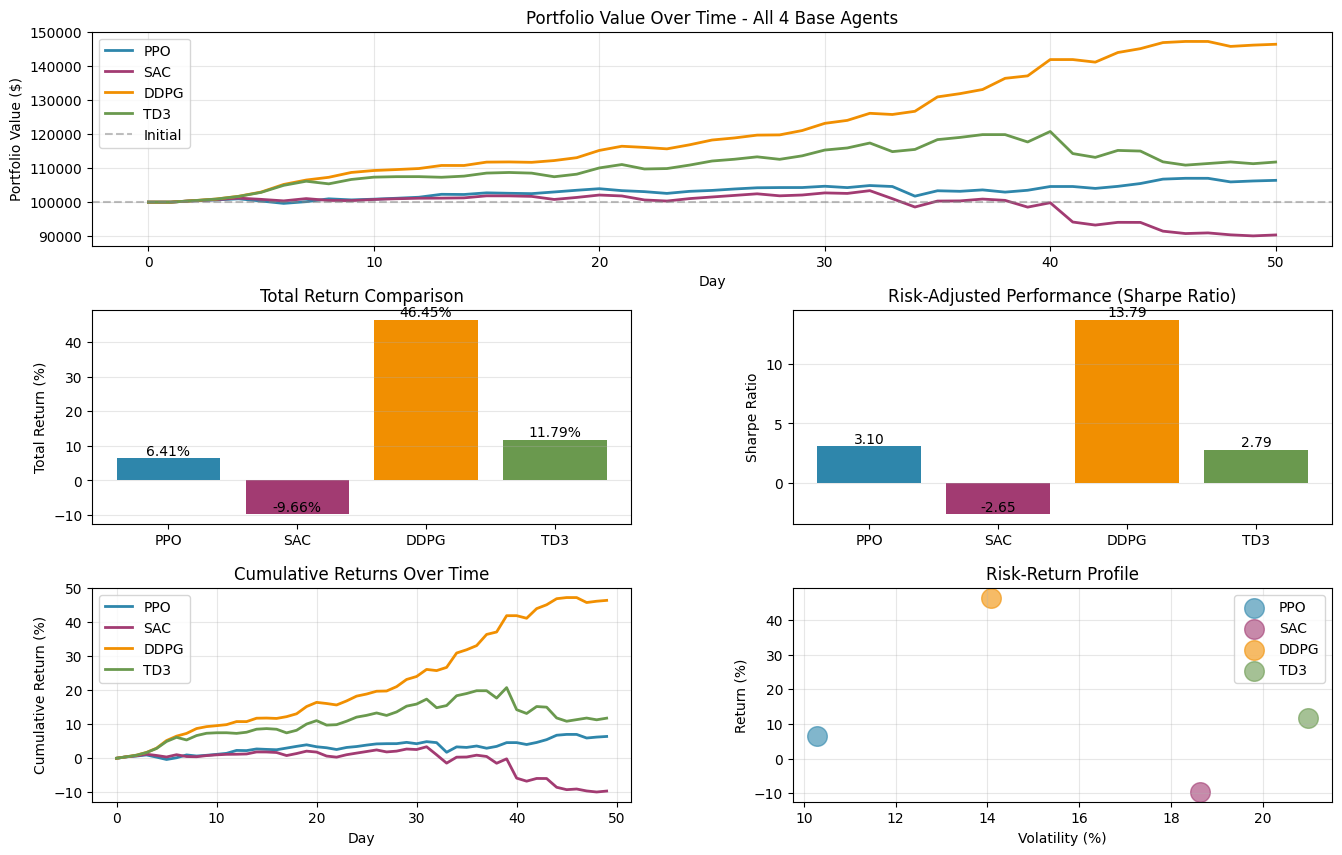

In [ ]:
# Evaluate and Compare All 4 Base Agents

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("Evaluating agents...")

# Store results for each agent
results = {}

for agent_name, model in base_agents.items():
    print(f"\nEvaluating {agent_name}...")


    eval_env = BasePortfolioEnv(market_data, sentiment_features_2assets)
    obs, _ = eval_env.reset()

    portfolio_values = [eval_env.initial_balance]
    allocations = []
    returns_per_step = []

    for step in range(50):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(action)

        portfolio_values.append(info['portfolio_value'])
        allocations.append(info['allocation'])
        returns_per_step.append(info['return'])

        if terminated or truncated:
            break

    # Calculate metrics
    final_value = portfolio_values[-1]
    total_return = (final_value - eval_env.initial_balance) / eval_env.initial_balance * 100
    sharpe_ratio = np.mean(returns_per_step) / (np.std(returns_per_step) + 1e-8) * np.sqrt(252)
    max_value = max(portfolio_values)
    min_value = min(portfolio_values)
    volatility = np.std(returns_per_step) * np.sqrt(252) * 100

    results[agent_name] = {
        'portfolio_values': portfolio_values,
        'final_value': final_value,
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'max_value': max_value,
        'min_value': min_value,
        'volatility': volatility,
        'allocations': allocations,
        'returns': returns_per_step
    }

    print(f"  Final Value: ${final_value:,.2f}")
    print(f"  Total Return: {total_return:.2f}%")
    print(f"  Sharpe Ratio: {sharpe_ratio:.3f}")

print("Performance Comparison")
comparison_df = pd.DataFrame({
    'Agent': list(results.keys()),
    'Final Value': [results[k]['final_value'] for k in results.keys()],
    'Return (%)': [results[k]['total_return'] for k in results.keys()],
    'Sharpe Ratio': [results[k]['sharpe_ratio'] for k in results.keys()],
    'Volatility (%)': [results[k]['volatility'] for k in results.keys()]
})
comparison_df = comparison_df.sort_values('Return (%)', ascending=False)
print(comparison_df.to_string(index=False))

t
best_agent = comparison_df.iloc[0]['Agent']
print(f"\nBest Agent: {best_agent}")

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Portfolio Value Comparison
ax1 = fig.add_subplot(gs[0, :])
colors = {'PPO': '#2E86AB', 'SAC': '#A23B72', 'DDPG': '#F18F01', 'TD3': '#6A994E'}
for agent_name, data in results.items():
    ax1.plot(data['portfolio_values'], label=agent_name, linewidth=2, color=colors[agent_name])
ax1.axhline(y=100000, color='gray', linestyle='--', alpha=0.5, label='Initial')
ax1.set_xlabel('Day')
ax1.set_ylabel('Portfolio Value ($)')
ax1.set_title('Portfolio Value Over Time - All 4 Base Agents')
ax1.legend()
ax1.grid(alpha=0.3)

# Return Comparison (Bar Chart)
ax2 = fig.add_subplot(gs[1, 0])
agents = list(results.keys())
returns = [results[k]['total_return'] for k in agents]
bars = ax2.bar(agents, returns, color=[colors[k] for k in agents])
ax2.set_ylabel('Total Return (%)')
ax2.set_title('Total Return Comparison')
ax2.grid(axis='y', alpha=0.3)

for bar, ret in zip(bars, returns):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{ret:.2f}%', ha='center', va='bottom')

# Sharpe Ratio Comparison (Bar Chart)
ax3 = fig.add_subplot(gs[1, 1])
sharpes = [results[k]['sharpe_ratio'] for k in agents]
bars = ax3.bar(agents, sharpes, color=[colors[k] for k in agents])
ax3.set_ylabel('Sharpe Ratio')
ax3.set_title('Risk-Adjusted Performance (Sharpe Ratio)')
ax3.grid(axis='y', alpha=0.3)
for bar, sharpe in zip(bars, sharpes):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{sharpe:.2f}', ha='center', va='bottom')

# Cumulative Returns Comparison
ax4 = fig.add_subplot(gs[2, 0])
for agent_name, data in results.items():
    cumulative = np.cumprod([1 + r for r in data['returns']]) - 1
    ax4.plot(cumulative * 100, label=agent_name, linewidth=2, color=colors[agent_name])
ax4.set_xlabel('Day')
ax4.set_ylabel('Cumulative Return (%)')
ax4.set_title('Cumulative Returns Over Time')
ax4.legend()
ax4.grid(alpha=0.3)

# Risk-Return Scatter
ax5 = fig.add_subplot(gs[2, 1])
for agent_name in agents:
    ax5.scatter(results[agent_name]['volatility'],
                results[agent_name]['total_return'],
                s=200, alpha=0.6, color=colors[agent_name], label=agent_name)
ax5.set_xlabel('Volatility (%)')
ax5.set_ylabel('Return (%)')
ax5.set_title('Risk-Return Profile')
ax5.legend()
ax5.grid(alpha=0.3)

plt.show()
